# Deep Image Prior for Denoising

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from dip.utils import load_image, add_noise, plot_image, plot_images
from dip.models import DIPNet

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

seed = 41
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

Using cache found in /home/duffy.se/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


cuda


## Model Definition and Training

![Hyperparameters](figures/reference_hyperparameters.png)

In [3]:
# Hyperparameters
w = 512
h = w
z_shape, u_range = (1, 3, w, h), (0, 0.1)
nu = nd = [128, 128, 128, 128, 128]
ku = kd = [3, 3, 3, 3, 3]
ns = [0, 0, 0, 4, 0] #[4, 4, 4, 4, 4]
ks = [1, 1, 1, 1, 1]
sigma_p = 1 / 30
epochs = 10000
lr = 0.01
upsampling = 'bilinear'

In [4]:
loss_function = nn.MSELoss()
loss_df = pd.DataFrame()

def train(image, show_intermediates=False, show_final=False, show_loss=True, logging_name=None, show_every=1000):
    model = DIPNet(nd=nd, kd=kd, nu=nu, ku=ku, ns=ns, ks=ks, d_in=z_shape, upsampling=upsampling).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    z = torch.rand(z_shape).uniform_(u_range[0], u_range[1]).to(device)

    losses = []
    out_avg = None
    for epoch in range(epochs):
        perturbed_z = z + (torch.randn_like(z) * sigma_p).clamp(0, 1)
        output = model(perturbed_z)
    
        optimizer.zero_grad()
        loss = loss_function(output, image)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
    
        if epoch % show_every == 0 or epoch == epochs - 1:
            if show_loss:
                print(f"Epoch [{epoch}/{epochs}] Loss: {loss.item():.6f}")
            if show_intermediates:
                with torch.no_grad():
                    output_image = model(z)
                    plot_image(output_image, title=f"Epoch {epoch}")
                
    if logging_name:
        loss_df[logging_name] = losses
        
    if show_final:
        plot_images([noisy_image, output_image], ['Original Image', 'Deep Image Prior Output'])

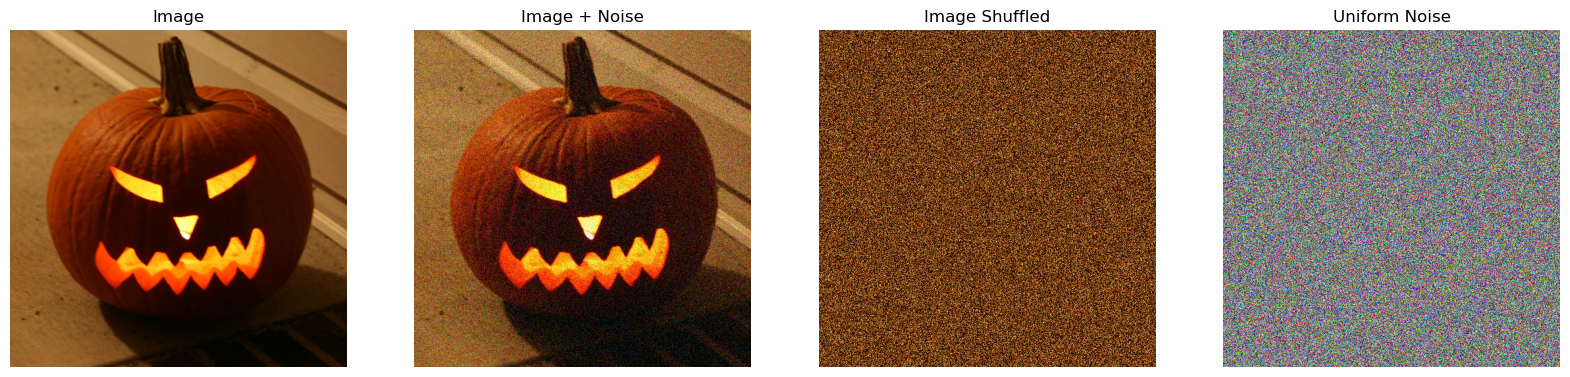

In [2]:
image_path = 'data/jack-o-lantern.jpg'
clean_image = load_image(image_path, target_size=(w, h), tensor=True).to(device) # Load image
noisy_image = add_noise(clean_image, noise_factor=0.1).unsqueeze(0).to(device) # Add noise to image
noise = torch.rand_like(clean_image).uniform_(0, 1).unsqueeze(0).to(device) # Create uniform noise
shuffled = clean_image.view(-1, clean_image.size(1) * clean_image.size(2))
shuffled = shuffled[:, torch.randperm(shuffled.size(1))]# Randomly shuffle image
shuffled = shuffled.view(clean_image.size()).unsqueeze(0).to(device)
clean_image = clean_image.unsqueeze(0)

plot_images([clean_image, noisy_image, shuffled, noise],
           ['Image', 'Image + Noise', 'Image Shuffled', 'Uniform Noise'])

Epoch [0/10000] Loss: 0.391132


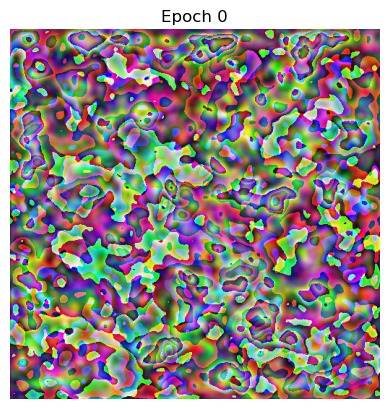

Epoch [1000/10000] Loss: 0.008456


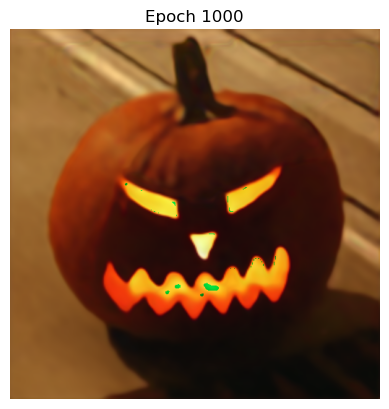

Epoch [2000/10000] Loss: 0.008303


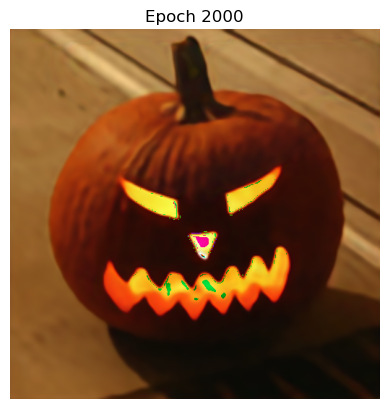

Epoch [3000/10000] Loss: 0.008049


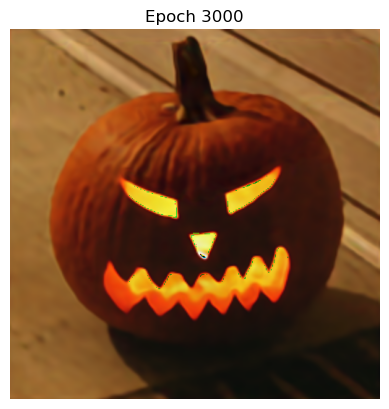

Epoch [4000/10000] Loss: 0.007798


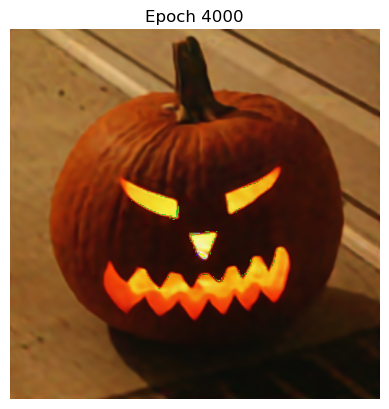

Epoch [5000/10000] Loss: 0.007703


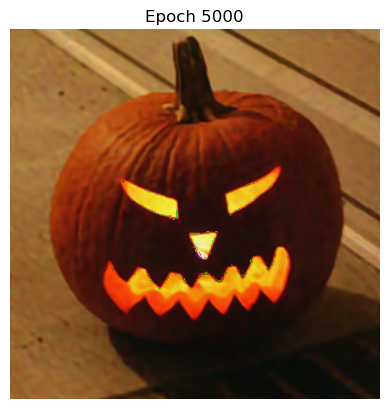

Epoch [6000/10000] Loss: 0.007650


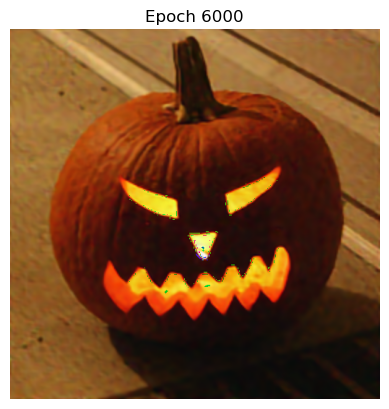

Epoch [7000/10000] Loss: 0.007500


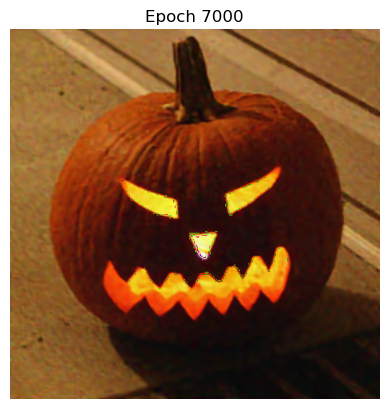

Epoch [8000/10000] Loss: 0.007420


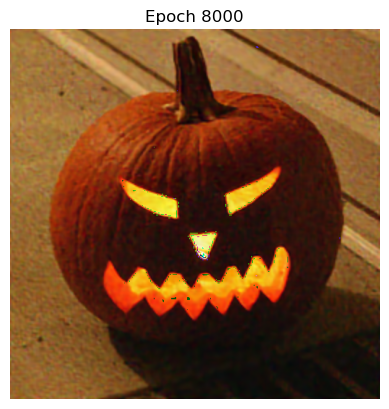

Epoch [9000/10000] Loss: 0.007356


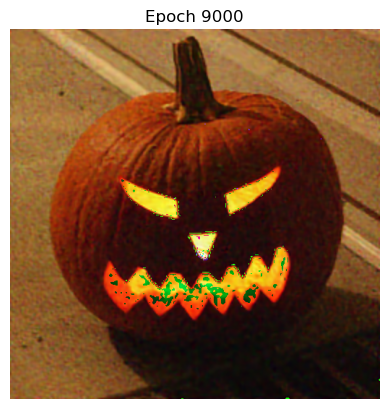

Epoch [9999/10000] Loss: 0.007041


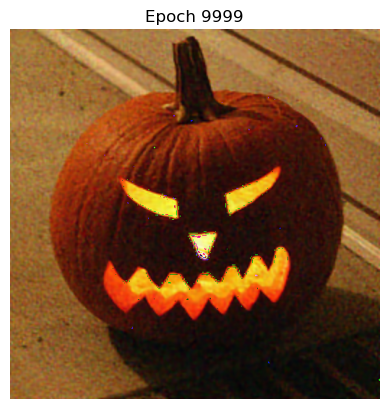

In [5]:
train(noisy_image, show_intermediates=True, logging_name='Image + Noise')

In [6]:
train(noise, show_loss=False, logging_name='Noise')

In [7]:
train(shuffled, show_loss=False, logging_name='Image Shuffled')

In [8]:
train(clean_image, show_loss=False, logging_name='Image')

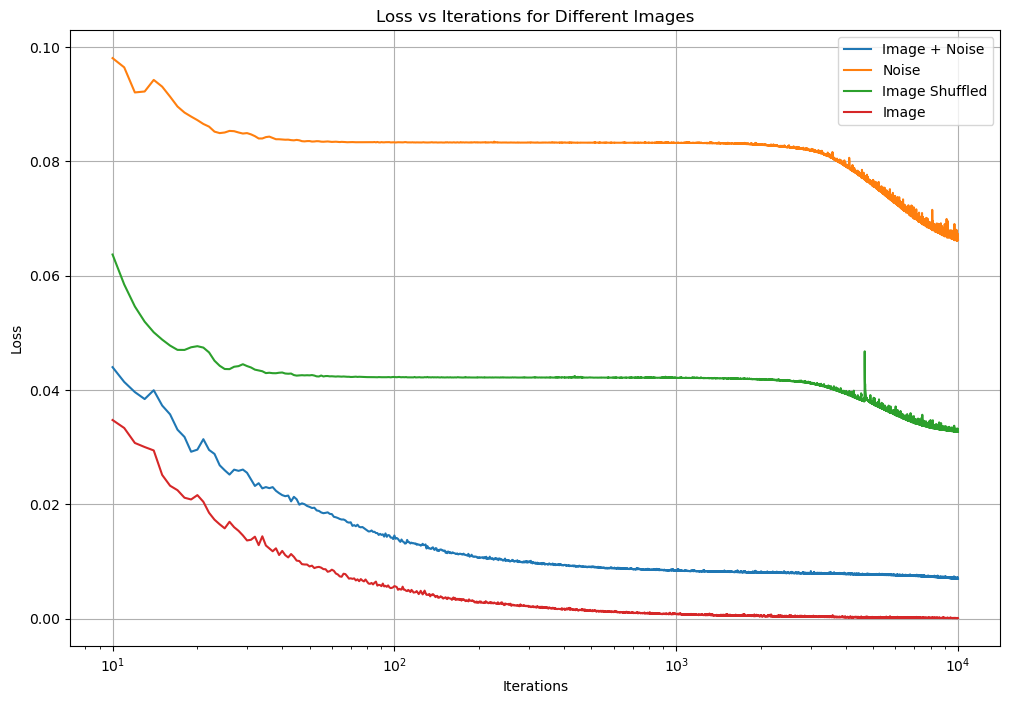

In [9]:
plt.figure(figsize=(12, 8))
for image_name in loss_df.columns:
    plt.plot(loss_df[image_name][10:], label=image_name)

plt.xlabel('Iterations')
plt.xscale('log')
plt.ylabel('Loss')
plt.title('Loss vs Iterations for Different Images')
plt.legend()
plt.grid(True)
plt.show()

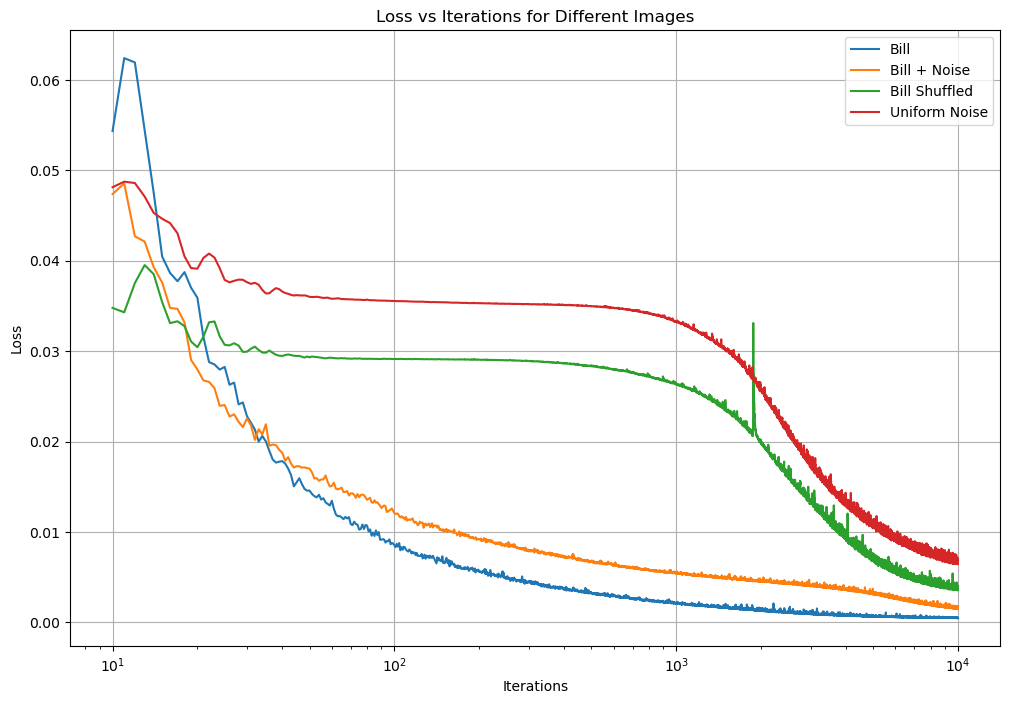

In [11]:
bill = load_image('data/bill_murray.png', target_size=(w, h), tensor=True).unsqueeze(0).to(device)
bill_noisy = load_image('data/bill_murray_noisy.png', target_size=(w, h), tensor=True).unsqueeze(0).to(device)
bill_shuffled = load_image('data/bill_murray_shuffled.png', target_size=(w, h), tensor=True).unsqueeze(0).to(device)
random_noise = load_image('data/random_noise.png', target_size=(w, h), tensor=True).unsqueeze(0).to(device)
train(bill, show_loss=False, logging_name='Bill')
train(bill_noisy, show_loss=False, logging_name='Bill + Noise')
train(bill_shuffled , show_loss=False, logging_name='Bill Shuffled')
train(random_noise, show_loss=False, logging_name='Uniform Noise')

plt.figure(figsize=(12, 8))
for image_name in ['Bill', 'Bill + Noise', 'Bill Shuffled', 'Uniform Noise']:
    plt.plot(loss_df[image_name][10:], label=image_name)

plt.xlabel('Iterations')
plt.xscale('log')
plt.ylabel('Loss')
plt.title('Loss vs Iterations for Different Images')
plt.legend()
plt.grid(True)
plt.show()

Epoch [0/10000] Loss: 0.688088


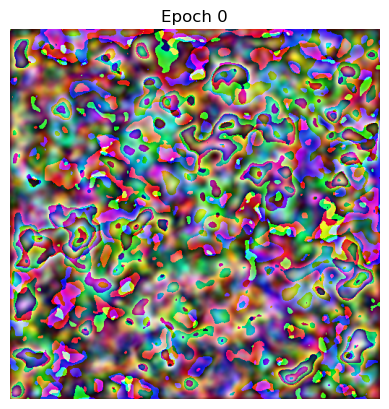

Epoch [1000/10000] Loss: 0.012561


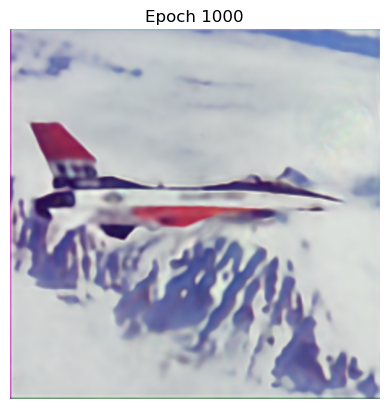

Epoch [2000/10000] Loss: 0.011594


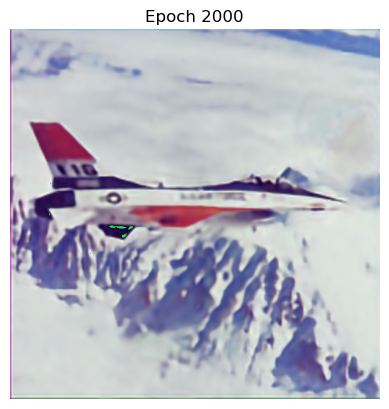

Epoch [3000/10000] Loss: 0.011072


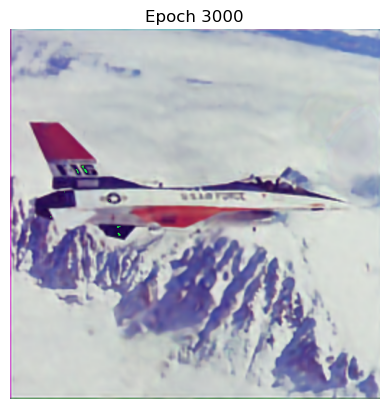

Epoch [4000/10000] Loss: 0.010505


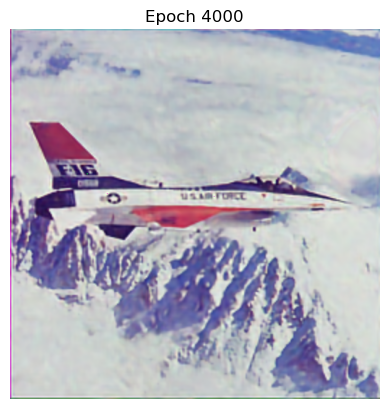

Epoch [5000/10000] Loss: 0.010304


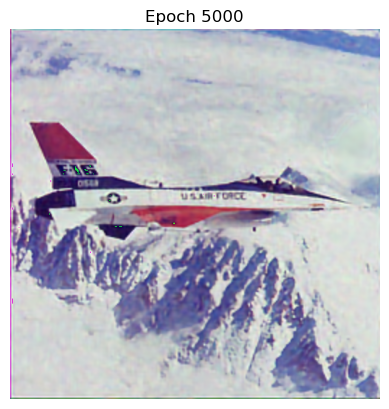

Epoch [6000/10000] Loss: 0.010056


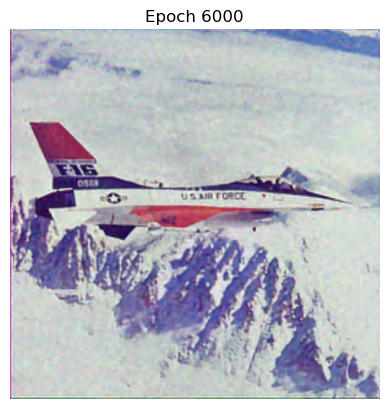

Epoch [7000/10000] Loss: 0.009931


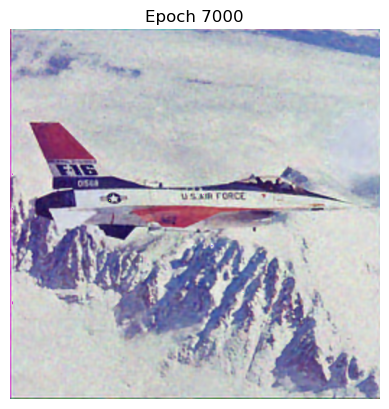

Epoch [8000/10000] Loss: 0.009901


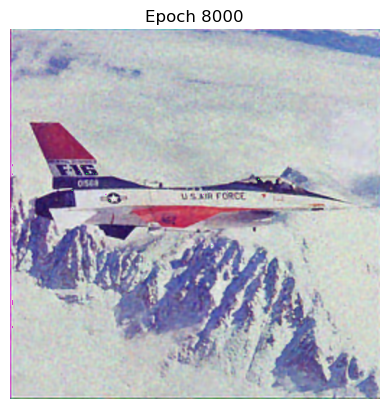

Epoch [9000/10000] Loss: 0.009305


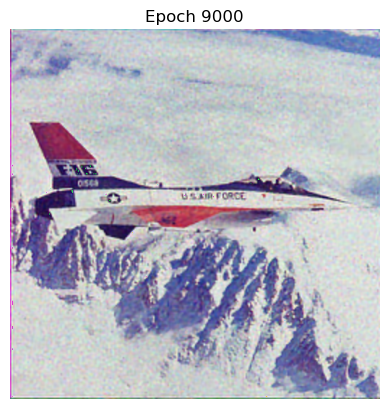

Epoch [9999/10000] Loss: 0.009313


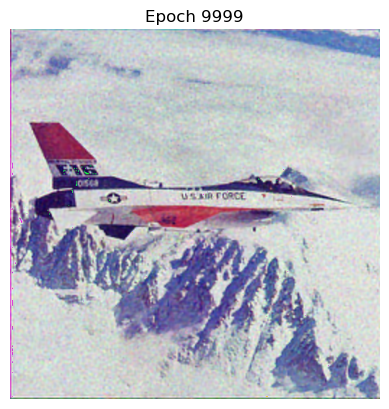

In [15]:
f16 = load_image('data/f16.png', target_size=(w, h), tensor=True).to(device)
f16 = add_noise(f16, noise_factor=0.1).unsqueeze(0).to(device)
train(f16, show_loss=True, show_intermediates=True, logging_name='F16')